# UK Retail dataset

Here we will focus on prediction engineering. Prediction engineering is a step in predictive modeling where we: 
* Define an outome we are interested in predicting 
* Scan the data to find the past occurences of the outcome 
* Make these past occurences training examples for machine learning/modeling

We will then use featuretools to extract features and learn a predictive model.
In this particular casestudy, we are focusing a retail dataset openly available at http://archive.ics.uci.edu/ml/datasets/online+retail
We will define the prediction problem as the one where the customer has more than k purchases

In [27]:
import featuretools as ft
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
ft.__version__

'0.9.1'

## Loading the data

Taking a sneak peak to one of the 'csv' files to see its structure

In [29]:
# Function to read and format the data inside the csv files
def load_uk_retail_data():
    item_purchases = pd.read_csv('Data/item_purchases.csv', encoding = 'unicode_escape')
    invoices = pd.read_csv('Data/invoices.csv', encoding = 'unicode_escape') 
    items = pd.read_csv('Data/items.csv', encoding = 'unicode_escape')
    customers = pd.read_csv('Data/customers.csv', encoding = 'unicode_escape')
    invoices['first_item_purchases_time'] = pd.to_datetime(
        invoices['first_item_purchases_time'], format="%m/%d/%y %H:%M")
    item_purchases['InvoiceDate'] = pd.to_datetime(
        item_purchases['InvoiceDate'], format="%m/%d/%y %H:%M")
    customers['first_invoices_time'] = pd.to_datetime(
        customers['first_invoices_time'], format="%m/%d/%y %H:%M")
    items['first_item_purchases_time'] = pd.to_datetime(
        items['first_item_purchases_time'], format="%m/%d/%y %H:%M")
    return item_purchases, invoices, items, customers

In [30]:
item_purchases, invoices, items, customers = load_uk_retail_data()

In [31]:
invoices = pd.read_csv('Data/invoices.csv', encoding = 'unicode_escape') 
# In order to avoid utf-8 codec error, the encoding should be set when reading the csv file
invoices.head()

,InvoiceNo,CustomerID,first_item_purchases_time
0,536365,17850.0,12/1/10 8:26
1,536366,17850.0,12/1/10 8:28
2,536367,13047.0,12/1/10 8:34
3,536368,13047.0,12/1/10 8:34
4,536369,13047.0,12/1/10 8:35


In [52]:
item_purchases.head()

,item_purchase_id,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice
0,0,536365,85123A,6,2010-12-01 08:26:00,2.55
1,1,536365,71053,6,2010-12-01 08:26:00,3.39
2,2,536365,84406B,8,2010-12-01 08:26:00,2.75
3,3,536365,84029G,6,2010-12-01 08:26:00,3.39
4,4,536365,84029E,6,2010-12-01 08:26:00,3.39


In [54]:
items.head()

,StockCode,Description,first_item_purchases_time
0,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00
1,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00
2,71053,WHITE METAL LANTERN,2010-12-01 08:26:00
3,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00
4,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00


In [55]:
customers.head()

,CustomerID,Country,first_invoices_time
0,17850.0,United Kingdom,2010-12-01 08:26:00
1,13047.0,United Kingdom,2010-12-01 08:34:00
2,12583.0,France,2010-12-01 08:45:00
3,13748.0,United Kingdom,2010-12-01 09:00:00
4,15100.0,United Kingdom,2010-12-01 09:09:00


## Shape of the datasets

In [49]:
print(item_purchases.shape, invoices.shape, items.shape, customers.shape)

(541909, 6) (25900, 3) (4070, 3) (4373, 3)


Now, let's see how many missing data we have for each one of the datasets

In [51]:
print(f'Number of missing data for: \n"item_purchases":\n{item_purchases.isna().sum()}')
print('*'*50)
print(f'Number of missing data for: \n"invoices":\n{invoices.isna().sum()}')
print('*'*50)
print(f'Number of missing data for: \n"items":\n{items.isna().sum()}')
print('*'*50)
print(f'Number of missing data for: \n"customers":\n{customers.isna().sum()}')
print('*'*50)

Number of missing data for: 
"item_purchases":
item_purchase_id    0
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
dtype: int64
**************************************************
Number of missing data for: 
"invoices":
InvoiceNo                       0
CustomerID                   3710
first_item_purchases_time       0
dtype: int64
**************************************************
Number of missing data for: 
"items":
StockCode                      0
Description                  176
first_item_purchases_time      0
dtype: int64
**************************************************
Number of missing data for: 
"customers":
CustomerID             1
Country                0
first_invoices_time    0
dtype: int64
**************************************************


From our simple EDA, we already see that there are many missing values in the 'invoice' dataset. One can simply think on making those values equal to zero, however the number of missing entries are considerable and such approach can lead to a bad estimation or, even, a overfitting of a future model.

## Visualization

<BarContainer object of 4373 artists>

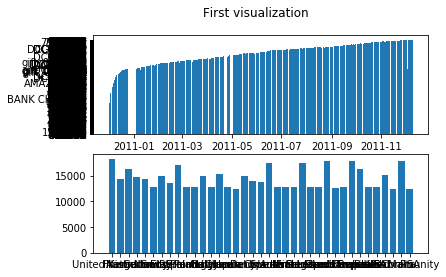

In [65]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('First visualization')
ax1.bar(item_purchases['InvoiceDate'], item_purchases['StockCode'])
ax2.bar(customers['Country'], customers['CustomerID'])

## Preparing the data

In [ ]:
# Entities and relationships betwen the datasets to be enter as parameters into featuretools 
entities = {
            "item_purchases": (item_purchases, "item_purchase_id", "InvoiceDate" ),
            "items": (items, "StockCode"),
            "customers": (customers,"CustomerID"),
            "invoices":(invoices,"InvoiceNo", "first_item_purchases_time")
            }
relationships = [("customers", "CustomerID","invoices", "CustomerID"),
                 ("invoices", "InvoiceNo","item_purchases", "InvoiceNo"),
                 ("items", "StockCode","item_purchases", "StockCode")]

In [ ]:
# To be used in the future...
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer


# set global random seed
np.random.seed(40)